In [1]:
# Reference: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn, optim

from collections import defaultdict
import seaborn as sns

In [2]:
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup

In [3]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 100

BATCH_SIZE = 4
EPOCHS = 3

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

In [4]:
full_df = pd.read_csv('data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
full_df = full_df.dropna() # dataset contains NaN values, dropping NaNs here

y_variables = ['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label', 
               'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label',
               'Input.deception_quadrant']

le = LabelEncoder()
full_df['Answer.1gamemove.yes_label'] = le.fit_transform(full_df['Answer.1gamemove.yes_label'])
full_df['Answer.2reasoning.yes_label'] = le.fit_transform(full_df['Answer.2reasoning.yes_label'])
full_df['Answer.3rapport.yes_label'] = le.fit_transform(full_df['Answer.3rapport.yes_label'])
full_df['Answer.4shareinformation.yes_label'] = le.fit_transform(full_df['Answer.4shareinformation.yes_label'])
full_df['Input.deception_quadrant'] = le.fit_transform(full_df['Input.deception_quadrant'])

df_train, df_test = train_test_split(full_df, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.2)

In [5]:
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, full_texts, y_vars, tokenizer, max_len):
        self.full_texts = full_texts
        self.y_vars = y_vars
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.full_texts)
    
    def __getitem__(self, item):
        full_text = str(self.full_texts[item])
        y = self.y_vars[item]
        encoding = self.tokenizer.encode_plus(
          full_text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'full_text': full_text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'y_vars': torch.tensor(y, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, y_var_name, max_len, batch_size):
    ds = Dataset(
        full_texts=df['Input.full_text'].to_numpy(),
        y_vars=df[y_var_name].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [6]:
class QuadrantClassifier(nn.Module):
    def __init__(self, n_classes):
        super(QuadrantClassifier, self).__init__()
        self.modelitem = model.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.modelitem.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.modelitem (
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [7]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        y_var = d["y_vars"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, y_var)
        correct_predictions += torch.sum(preds == y_var)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [8]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            y_var = d["y_vars"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, y_var)
            correct_predictions += torch.sum(preds == y_var)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [9]:
def get_predictions(model, data_loader):
    model = model.eval()
    full_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["full_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            y_var = d["y_vars"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )
            
            _, preds = torch.max(outputs, dim=1)
            full_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(y_var)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return full_texts, predictions, prediction_probs, real_values

In [10]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True')
    plt.xlabel('Predicted')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


device:  cuda:0
Answer.1gamemove.yes_label
sanity checks
dict_keys(['full_text', 'input_ids', 'attention_mask', 'y_vars'])
torch.Size([4, 100])
torch.Size([4, 100])


C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 1/3
----------
Train loss 0.5582481473356524 accuracy 0.8218213814342279
Epoch 2/3
----------
Train loss 0.5600813775926867 accuracy 0.8174219093708756
Epoch 3/3
----------
Train loss 0.5634188818685084 accuracy 0.8173119225692917
Test accuracy:  0.9406593406593406


C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000   27.000000
1              0.940659  1.000000  0.969422  428.000000
accuracy       0.940659  0.940659  0.940659    0.940659
macro avg      0.470330  0.500000  0.484711  455.000000
weighted avg   0.884840  0.940659  0.911896  455.000000
None
Answer.2reasoning.yes_label
sanity checks
dict_keys(['full_text', 'input_ids', 'attention_mask', 'y_vars'])
torch.Size([4, 100])
torch.Size([4, 100])
Epoch 1/3
----------
Train loss 0.7519910188299205 accuracy 0.3869335679718434
Epoch 2/3
----------
Train loss 0.7501034209553072 accuracy 0.3901231852177739
Epoch 3/3
----------
Train loss 0.7528082793156481 accuracy 0.3850637923449186
Test accuracy:  0.1912087912087912
              precision    recall  f1-score     support
0              0.185268  0.965116  0.310861   86.000000
1              0.571429  0.010840  0.021277  369.000000
accuracy       0.191209  0.191209  0.191209    0.191209
macro avg    

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 1/3
----------
Train loss 0.7137303485043816 accuracy 0.47910250769907614
Epoch 2/3
----------
Train loss 0.7117811116126472 accuracy 0.49010118785745715
Epoch 3/3
----------
Train loss 0.7153287554594897 accuracy 0.48251209854817423
Test accuracy:  0.3956043956043956
              precision    recall  f1-score     support
0              0.176849  0.743243  0.285714   74.000000
1              0.868056  0.328084  0.476190  381.000000
accuracy       0.395604  0.395604  0.395604    0.395604
macro avg      0.522452  0.535664  0.380952  455.000000
weighted avg   0.755640  0.395604  0.445212  455.000000
None
Answer.4shareinformation.yes_label
sanity checks
dict_keys(['full_text', 'input_ids', 'attention_mask', 'y_vars'])
torch.Size([4, 100])
torch.Size([4, 100])


C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 1/3
----------
Train loss 0.6522837061872578 accuracy 0.6283545974483062
Epoch 2/3
----------
Train loss 0.6571688824323008 accuracy 0.6212054553453585
Epoch 3/3
----------
Train loss 0.6537962814574193 accuracy 0.6290145182578091
Test accuracy:  0.8241758241758241
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000   69.000000
1              0.844595  0.971503  0.903614  386.000000
accuracy       0.824176  0.824176  0.824176    0.824176
macro avg      0.422297  0.485751  0.451807  455.000000
weighted avg   0.716513  0.824176  0.766583  455.000000
None
Input.deception_quadrant
sanity checks
dict_keys(['full_text', 'input_ids', 'attention_mask', 'y_vars'])
torch.Size([4, 100])
torch.Size([4, 100])


C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 1/3
----------
Train loss 1.1923349877836629 accuracy 0.05499340079190498
Epoch 2/3
----------
Train loss 1.1976342823502255 accuracy 0.053233611966564016
Epoch 3/3
----------
Train loss 1.1959983079747067 accuracy 0.053453585569731635
Test accuracy:  0.054945054945054944


C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score     support
0              0.054945  1.000000  0.104167   25.000000
1              0.000000  0.000000  0.000000  430.000000
accuracy       0.054945  0.054945  0.054945    0.054945
macro avg      0.027473  0.500000  0.052083  455.000000
weighted avg   0.003019  0.054945  0.005723  455.000000
None


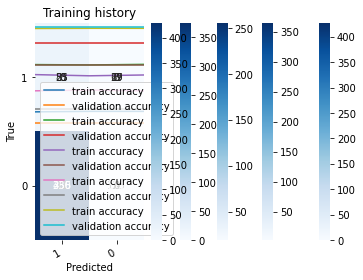

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)


for y_var in y_variables:
    print(y_var)
    
    # Create data splits
    train_data_loader = create_data_loader(df_train, tokenizer, y_var, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, y_var, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, y_var, MAX_LEN, BATCH_SIZE)
    
    # Sainty checks
    print('sanity checks')
    data = next(iter(train_data_loader))
    print(data.keys())
    print(data['input_ids'].shape)
    print(data['attention_mask'].shape)
    
    class_names = df_train[y_var].unique()
    
    # Create classifier model
    new_model = QuadrantClassifier(len(class_names))
    new_model = new_model.to(device)
    
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    
    # Add softmax final layer 
    nn.functional.softmax(new_model(input_ids, attention_mask), dim=1)

    # Compile model for number of epochs
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    # Do training
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        train_acc, train_loss = train_epoch(
            new_model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            new_model,
            val_data_loader,
            loss_fn,
            device,
            len(df_val)
          )

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
    
    # Plot values 
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);
    
    test_acc, _ = eval_model(
      new_model,
      test_data_loader,
      loss_fn,
      device,
      len(df_test)
    )
    print('Test accuracy: ', test_acc.item())
    
    # Get predictions
    y_full_texts, y_pred, y_pred_probs, y_test = get_predictions(
      new_model,
      test_data_loader
    )
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()

    # Classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True)
    print(pd.DataFrame(report).transpose())
    
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    show_confusion_matrix(df_cm)
    
    # Clear GPU memory
    del input_ids
    del attention_mask
    del new_model
    del loss_fn
    
    print(torch.cuda.empty_cache())